In [753]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve ,confusion_matrix , precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [754]:
# Read training data
train_dataset = pd.read_csv('/kaggle/input/titanic/train.csv')
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [755]:
# Read testing data
test_dataset = pd.read_csv('/kaggle/input/titanic/test.csv')
test_dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [756]:
all_data = train_dataset.append(test_dataset)
all_data.shape

(1309, 12)

# Understanding Train dataset

In [757]:
train_dataset.shape

(891, 12)

In [758]:
train_dataset.info(verbose = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [759]:
train_dataset.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Honkanen, Miss. Eliina",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [760]:
num_col = ['Age', 'SibSp', 'Parch', 'Fare']
cat_col = ['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']

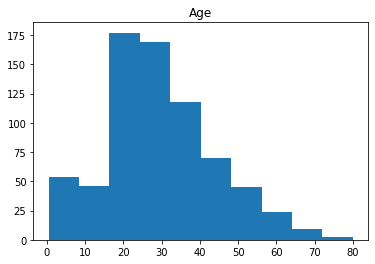

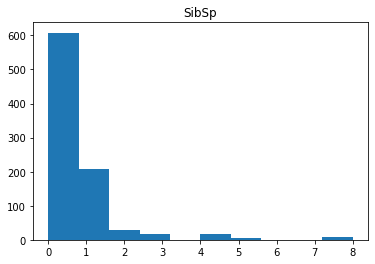

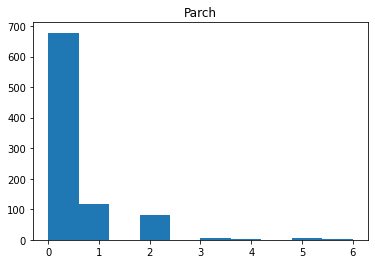

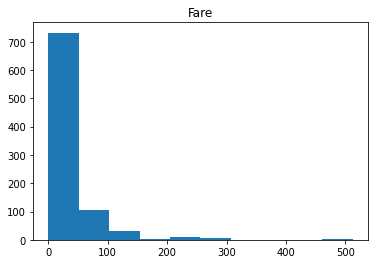

In [761]:
for col in num_col:
    plt.hist(train_dataset[col])
    plt.title(col)
    plt.show()

### From the above plots we can see that only Age follows a normal distribution

<AxesSubplot:>

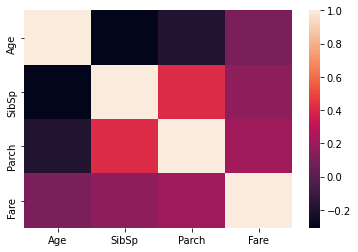

In [762]:
corr = train_dataset[num_col].corr()
sns.heatmap(corr)

### Clearly, Parch and SibSp have high correlation

In [763]:
pd.pivot_table(train_dataset, index="Survived", values=num_col)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


### Looks like, people that payed more fare survived, younger people survived

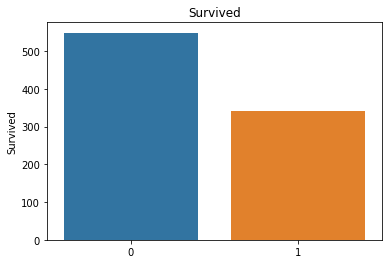

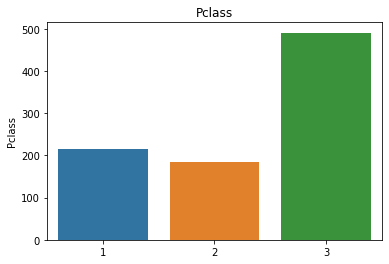

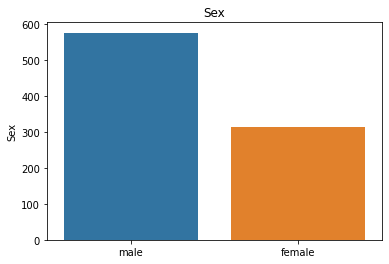

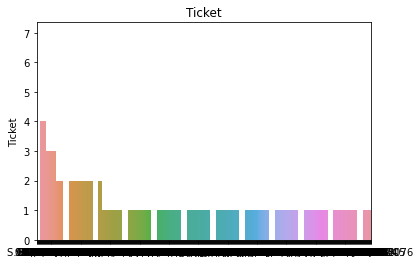

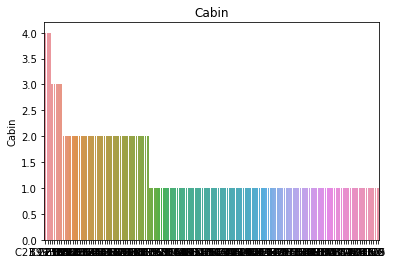

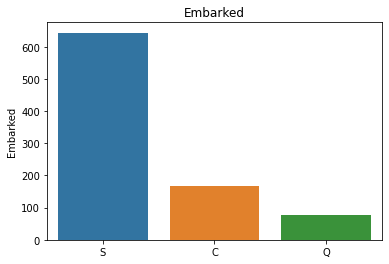

In [764]:
for col in cat_col:
    sns.barplot(x = train_dataset[col].value_counts().index, y = train_dataset[col].value_counts()).set_title(col)
    plt.show()

In [765]:
pd.pivot_table(train_dataset, index="Survived", columns="Pclass",
               values="Ticket", aggfunc="count")

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


### First class survival ratio is way more the survival ratio of 3rd class. Clearly the rich people survived more

In [766]:
pd.pivot_table(train_dataset, index="Survived", columns="Sex",
               values="Ticket", aggfunc="count")

Sex,female,male
Survived,,
0,81,468
1,233,109


### As observed, female survival ratio is much higher than male survival ratio

In [767]:
pd.pivot_table(train_dataset, index="Survived", columns="Embarked",
               values="Ticket", aggfunc="count")

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [768]:
train_dataset['Cabin_split'] = train_dataset['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
test_dataset['Cabin_split'] = test_dataset['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

train_dataset['Cabin_split'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: Cabin_split, dtype: int64

In [769]:
pd.pivot_table(train_dataset, index="Survived", columns="Cabin_split",
               values="Ticket", aggfunc="count")

Cabin_split,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [770]:
train_dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [771]:
train_dataset['Name_title'] = train_dataset['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_dataset['Name_title'] = test_dataset['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

train_dataset['Name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Capt              1
Lady              1
Ms                1
Jonkheer          1
Mme               1
Sir               1
Don               1
the Countess      1
Name: Name_title, dtype: int64

## Missing values inspection

In [772]:
round(all_data.isnull().sum() * 100 / all_data.shape[0], 2)

PassengerId     0.00
Survived       31.93
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.09
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.08
Cabin          77.46
Embarked        0.15
dtype: float64

#### Clearly cabin has a lot of missing values, we can drop this column

In [773]:
# Imputing for age column with mean age
mean_age = int(all_data.Age.mean())
all_data.Age.fillna(mean_age, inplace = True)

mean_fare = int(all_data.Age.mean())
all_data.Age.fillna(mean_age, inplace = True)

In [774]:
all_data['Cabin_split'] = all_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['Name_title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Numeric_ticket'] = all_data['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)


In [775]:
# dropping na from Embarked
all_data.dropna(subset=["Embarked"], inplace=True)
all_data.shape

(1307, 15)

<AxesSubplot:>

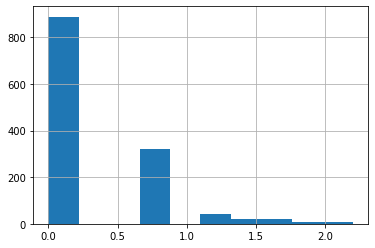

In [776]:
all_data['norm_sibsp'] = np.log(all_data['SibSp'] + 1)
all_data['norm_sibsp'].hist()

<AxesSubplot:>

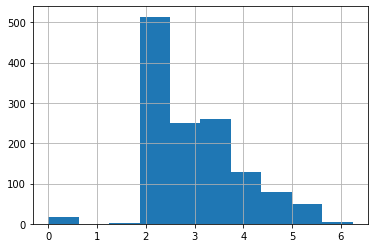

In [777]:
all_data['norm_fare'] = np.log(all_data['Fare'] + 1)
all_data['norm_fare'].hist()

In [778]:
round(all_data.isnull().sum() * 100 / all_data.shape[0], 2)

PassengerId        0.00
Survived          31.98
Pclass             0.00
Name               0.00
Sex                0.00
Age                0.00
SibSp              0.00
Parch              0.00
Ticket             0.00
Fare               0.08
Cabin             77.58
Embarked           0.00
Cabin_split        0.00
Name_title         0.00
Numeric_ticket     0.00
norm_sibsp         0.00
norm_fare          0.08
dtype: float64

In [779]:
all_data['norm_fare'] = all_data['norm_fare'].fillna(all_data['norm_fare'].median())

In [780]:
round(all_data.isnull().sum() * 100 / all_data.shape[0], 2)

PassengerId        0.00
Survived          31.98
Pclass             0.00
Name               0.00
Sex                0.00
Age                0.00
SibSp              0.00
Parch              0.00
Ticket             0.00
Fare               0.08
Cabin             77.58
Embarked           0.00
Cabin_split        0.00
Name_title         0.00
Numeric_ticket     0.00
norm_sibsp         0.00
norm_fare          0.00
dtype: float64

In [781]:
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_split,Name_title,Numeric_ticket,norm_sibsp,norm_fare
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,0,0.693147,2.110213
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,0,0.693147,4.280593
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,0,0.000000,2.188856
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs,1,0.693147,3.990834
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr,1,0.000000,2.202765


In [782]:
# Map categorical columns
all_data.Sex = all_data.Sex.map({ 'female': 0, 'male': 1 })

In [783]:
all_data.Embarked = all_data.Embarked.map({ 'S': 0, 'C': 1, 'Q': 2 })

In [784]:
all_data['Survived'].unique()

array([ 0.,  1., nan])

In [785]:
all_data.drop(['Name', 'Ticket', 'Cabin', 'Fare'], axis = 1, inplace = True)

# EDA

# Dummy Categorical Columns

In [786]:
all_data = pd.get_dummies(data = all_data, columns = ['SibSp', 'Pclass', 'Parch', 'Embarked', 'Cabin_split', 'Name_title'], drop_first = True)
all_data.head()

,PassengerId,Survived,Sex,Age,Numeric_ticket,norm_sibsp,norm_fare,SibSp_1,SibSp_2,SibSp_3,...,Name_title_Master,Name_title_Miss,Name_title_Mlle,Name_title_Mme,Name_title_Mr,Name_title_Mrs,Name_title_Ms,Name_title_Rev,Name_title_Sir,Name_title_the Countess
0,1,0.0,1,22.0,0,0.693147,2.110213,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,1.0,0,38.0,0,0.693147,4.280593,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1.0,0,26.0,0,0.000000,2.188856,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4,1.0,0,35.0,1,0.693147,3.990834,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,0.0,1,35.0,1,0.000000,2.202765,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [787]:
all_data = all_data.set_index('PassengerId')

In [788]:
test_dataset = all_data.loc[all_data['Survived'].isnull()]
train_dataset = all_data.loc[all_data['Survived'].notnull()]

# Train-test split

In [789]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(train_dataset, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(622, 44)
(267, 44)


# Feature scaling

In [790]:
y_train = df_train['Survived']
X_train = df_train.drop(['Survived'], axis = 1)

In [791]:
y_test = df_test['Survived']
X_test = df_test.drop(['Survived'], axis = 1)

In [792]:
X_train.head()

,Sex,Age,Numeric_ticket,norm_sibsp,norm_fare,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,...,Name_title_Master,Name_title_Miss,Name_title_Mlle,Name_title_Mme,Name_title_Mr,Name_title_Mrs,Name_title_Ms,Name_title_Rev,Name_title_Sir,Name_title_the Countess
PassengerId,,,,,,,,,,,,,,,,,,,,,
87,1,16.0,0,0.693147,3.566005,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
890,1,26.0,1,0.000000,3.433987,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
163,1,26.0,1,0.000000,2.171907,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
761,1,29.0,1,0.000000,2.740840,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
410,0,29.0,1,1.386294,3.275887,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [793]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[['Age', 'norm_sibsp', 'norm_fare']] = scaler.fit_transform(X_train[['Age', 'norm_sibsp', 'norm_fare']])
X_test[['Age', 'norm_sibsp', 'norm_fare']] = scaler.transform(X_test[['Age', 'norm_sibsp', 'norm_fare']])
test_dataset[['Age', 'norm_sibsp', 'norm_fare']] = scaler.transform(test_dataset[['Age', 'norm_sibsp', 'norm_fare']])
X_train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,Sex,Age,Numeric_ticket,norm_sibsp,norm_fare,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,...,Name_title_Master,Name_title_Miss,Name_title_Mlle,Name_title_Mme,Name_title_Mr,Name_title_Mrs,Name_title_Ms,Name_title_Rev,Name_title_Sir,Name_title_the Countess
PassengerId,,,,,,,,,,,,,,,,,,,,,
87,1,0.211742,0,0.315465,0.571391,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
890,1,0.347649,1,0.000000,0.550238,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
163,1,0.347649,1,0.000000,0.348011,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
761,1,0.388421,1,0.000000,0.439173,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
410,0,0.388421,1,0.630930,0.524905,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [794]:
result_column_names = ["Model", "AuC Score"]
model_results = pd.DataFrame(columns = result_column_names)

# Logistic Regression using RFE

In [795]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')

In [796]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 10)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [797]:
## list columns that rfe predicted as useful
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Sex', True, 1),
 ('Age', True, 1),
 ('Numeric_ticket', False, 20),
 ('norm_sibsp', True, 1),
 ('norm_fare', True, 1),
 ('SibSp_1', False, 10),
 ('SibSp_2', False, 12),
 ('SibSp_3', True, 1),
 ('SibSp_4', False, 17),
 ('SibSp_5', True, 1),
 ('SibSp_8', False, 2),
 ('Pclass_2', False, 8),
 ('Pclass_3', True, 1),
 ('Parch_1', False, 24),
 ('Parch_2', False, 22),
 ('Parch_3', False, 25),
 ('Parch_4', True, 1),
 ('Parch_5', False, 6),
 ('Parch_6', False, 9),
 ('Parch_9', False, 32),
 ('Embarked_1', False, 13),
 ('Embarked_2', False, 21),
 ('Cabin_split_1', True, 1),
 ('Cabin_split_2', False, 23),
 ('Cabin_split_3', False, 4),
 ('Cabin_split_4', False, 26),
 ('Name_title_Col', False, 19),
 ('Name_title_Don', False, 14),
 ('Name_title_Dona', False, 29),
 ('Name_title_Dr', False, 16),
 ('Name_title_Jonkheer', False, 31),
 ('Name_title_Lady', False, 30),
 ('Name_title_Major', False, 11),
 ('Name_title_Master', True, 1),
 ('Name_title_Miss', False, 15),
 ('Name_title_Mlle', False, 27),
 ('Nam

In [798]:
rfe_col = X_train.columns[rfe.support_]
rfe_col

Index(['Sex', 'Age', 'norm_sibsp', 'norm_fare', 'SibSp_3', 'SibSp_5',
       'Pclass_3', 'Parch_4', 'Cabin_split_1', 'Name_title_Master'],
      dtype='object')

# Using Statsmodel

In [799]:
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train[rfe_col])
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  622
Model:                            GLM   Df Residuals:                      611
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -254.02
Date:                Mon, 31 May 2021   Deviance:                       508.04
Time:                        20:16:57   Pearson chi2:                     671.
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.5014      0.681      2.206      0.027       0.167       2.836
Sex                  -2.9678      0.261    -11.389      0.000      -3.479      -2.457
Age                  -1.9543      0.755     -2.588      0.010      -3.434      -0.474
norm_sibsp           -1.9691      0.687     -2.868      0.004      -3.315      -0.623
norm_fare             2.3584      1.080      2.184      0.029       0.242       4.474
SibSp_3              -1.0938      0.708     -1.546      0.122      -2.481       0.293
SibSp_5             -21.7956   2.12e+04     -0.001      0.999   -4.15e+04    4.15e+04
Pclass_3             -1.2412      0.309     -4.021      0.000      -1.846      -0.636
Parch_4             -22.3219    2.5e+04     -0.001      0.999   -4.91e+04     4.9e+04
Cabin_split_1         0.9873      0.320      3.084      0.002       0.360       1.615
Name_title_Master     2.7785      0.607      4.580      0.000       1.589       3.968
=====================================================================================
"""

In [800]:
#Drop parch_4
rfe_col = rfe_col.drop('Parch_4')

In [801]:
logmodel = sm.GLM(y_train, X_train_sm[rfe_col], family = sm.families.Binomial())
res = logmodel.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  622
Model:                            GLM   Df Residuals:                      613
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -258.63
Date:                Mon, 31 May 2021   Deviance:                       517.26
Time:                        20:16:57   Pearson chi2:                     691.
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Sex                  -2.7976      0.249    -11.228      0.000      -3.286      -2.309
Age                  -1.3830      0.674     -2.050      0.040      -2.705      -0.061
norm_sibsp           -2.2446      0.670     -3.352      0.001      -3.557      -0.932
norm_fare             4.2615      0.697      6.117      0.000       2.896       5.627
SibSp_3              -1.0558      0.712     -1.483      0.138      -2.451       0.340
SibSp_5             -20.9219   1.29e+04     -0.002      0.999   -2.53e+04    2.53e+04
Pclass_3             -0.7787      0.216     -3.611      0.000      -1.201      -0.356
Cabin_split_1         0.9341      0.315      2.961      0.003       0.316       1.552
Name_title_Master     2.8008      0.594      4.716      0.000       1.637       3.965
=====================================================================================
"""

In [802]:
# Drop SibSp_8
rfe_col = rfe_col.drop('SibSp_5')

In [803]:
logmodel = sm.GLM(y_train, X_train_sm[rfe_col], family = sm.families.Binomial())
res = logmodel.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  622
Model:                            GLM   Df Residuals:                      614
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -260.41
Date:                Mon, 31 May 2021   Deviance:                       520.82
Time:                        20:16:57   Pearson chi2:                     700.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Sex                  -2.8103      0.250    -11.254      0.000      -3.300      -2.321
Age                  -1.3439      0.672     -1.999      0.046      -2.662      -0.026
norm_sibsp           -2.4607      0.660     -3.727      0.000      -3.755      -1.167
norm_fare             4.2811      0.696      6.153      0.000       2.917       5.645
SibSp_3              -0.9130      0.709     -1.288      0.198      -2.302       0.476
Pclass_3             -0.7868      0.215     -3.651      0.000      -1.209      -0.364
Cabin_split_1         0.9396      0.315      2.982      0.003       0.322       1.557
Name_title_Master     2.7237      0.580      4.694      0.000       1.586       3.861
=====================================================================================
"""

In [804]:
#Drop SibSp_5
rfe_col = rfe_col.drop('SibSp_3')

In [805]:
logmodel = sm.GLM(y_train, X_train_sm[rfe_col], family = sm.families.Binomial())
res = logmodel.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  622
Model:                            GLM   Df Residuals:                      615
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -261.30
Date:                Mon, 31 May 2021   Deviance:                       522.60
Time:                        20:16:57   Pearson chi2:                     705.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Sex                  -2.8091      0.250    -11.225      0.000      -3.300      -2.319
Age                  -1.2891      0.666     -1.934      0.053      -2.595       0.017
norm_sibsp           -2.7332      0.635     -4.305      0.000      -3.977      -1.489
norm_fare             4.2496      0.693      6.136      0.000       2.892       5.607
Pclass_3             -0.7914      0.215     -3.678      0.000      -1.213      -0.370
Cabin_split_1         0.9602      0.314      3.056      0.002       0.344       1.576
Name_title_Master     2.7713      0.577      4.806      0.000       1.641       3.901
=====================================================================================
"""

In [806]:
### Checking VIF values
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,norm_fare,8.43
1,Age,7.12
0,Sex,3.13
4,Pclass_3,2.19
2,norm_sibsp,1.97
5,Cabin_split_1,1.82
6,Name_title_Master,1.49


In [808]:
log_rfe = LogisticRegression(class_weight='balanced')
log_rfe.fit(X_train[rfe_col], y_train)

y_train_pred = log_rfe.predict(X_train[rfe_col])

y_test_pred = log_rfe.predict(X_test[rfe_col])

In [809]:
print("AUC score (train): ", roc_auc_score(y_train, y_train_pred))
print("AUC score (test): ", roc_auc_score(y_test, y_test_pred))

AUC score (train):  0.8018910599424076
AUC score (test):  0.8112149532710281


### Model performs with an accuracy of 81.12% on test dataset, which is a decent performance by the model

In [810]:
model_results = model_results.append({ 
    result_column_names[0]: 'Logistic Regression using RFE', 
    result_column_names[1]: roc_auc_score(y_test, y_test_pred) }, ignore_index = True)
model_results

,Model,AuC Score
0,Logistic Regression using RFE,0.811215


# Let's try Logistic Regression with PCA

In [811]:
##initialize and fit pca
pca = PCA(random_state = 42)
pca.fit(X_train)

PCA(random_state=42)

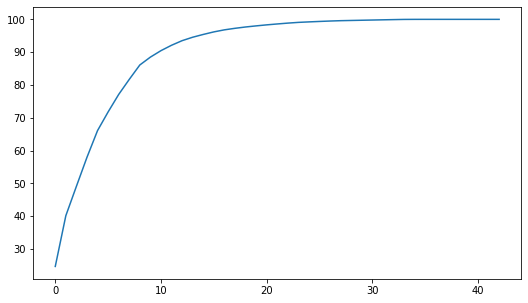

In [812]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

In [813]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.24698488, 0.40166808, 0.491175  , 0.57964662, 0.66101808,
       0.71782769, 0.7711227 , 0.81698969, 0.86092423, 0.88491418,
       0.90460979, 0.92102916, 0.93501624, 0.94550892, 0.95399812,
       0.96174711, 0.96801082, 0.97268384, 0.97671853, 0.98008228,
       0.98319483, 0.98595039, 0.98853692, 0.99075464, 0.99225687,
       0.99362612, 0.99489056, 0.99594826, 0.99661376, 0.99727646,
       0.99793089, 0.99857555, 0.99921312, 0.99979812, 0.99996177,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

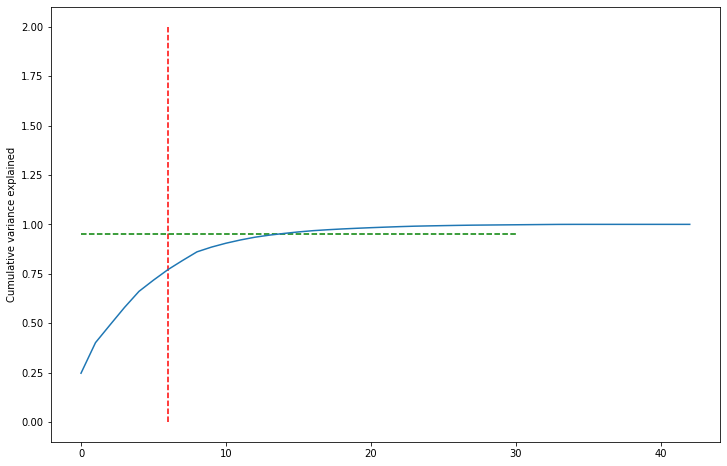

In [814]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=6, ymax=2, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [815]:
pca_final = PCA(0.99, svd_solver='full')

In [816]:
df_train_pca = pca_final.fit_transform(X_train)

In [817]:
df_train_pca.shape

(622, 24)

### PCA has chosen 24 parameters that explain 99% variance

<AxesSubplot:>

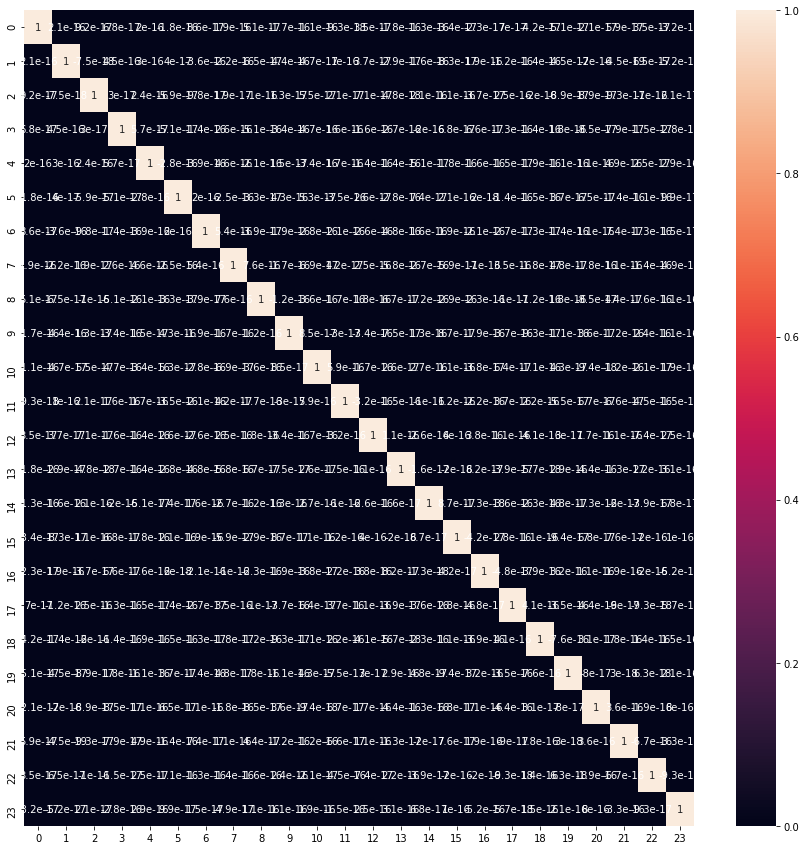

In [818]:
corrmat = np.corrcoef(df_train_pca.transpose())
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

### Clearly there is no correlation in PCA parameters

In [819]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(267, 24)

In [820]:
# logistic regression - the class weight is used to handle class imbalance - 
#it adjusts the cost function
logistic = LogisticRegression(class_weight='balanced')

# hyperparameter space
params = {'C': [0.1, 0.2, 0.4, 0.5, 1, 2], 'penalty': ['l1', 'l2']}

# create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# create gridsearch object
log_pca = GridSearchCV(estimator=logistic, cv=folds,
                     param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [821]:
# fit model
log_pca.fit(df_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.85835458        nan 0.85828114        nan 0.86002631
        nan 0.86077037        nan 0.8603341         nan 0.85962467]
  category=UserWarning


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.4, 0.5, 1, 2],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [822]:
# print best hyperparameters
print("Best AUC: ", log_pca.best_score_)
print("Best hyperparameters: ", log_pca.best_params_)
print(log_pca.best_estimator_)

Best AUC:  0.8607703660575252
Best hyperparameters:  {'C': 0.5, 'penalty': 'l2'}
LogisticRegression(C=0.5, class_weight='balanced')


In [824]:
y_pred_prob_train = log_pca.predict(df_train_pca)
print("AUC score (train):", roc_auc_score(y_train, y_pred_prob_train))

AUC score (train): 0.8168904531262068


In [825]:
y_pred_prob_test = log_pca.predict(df_test_pca)
print("AUC score (test):", roc_auc_score(y_test, y_pred_prob_test))

AUC score (test): 0.8112149532710281


In [826]:
model_results = model_results.append({ 
    result_column_names[0]: 'Logistic Regression using PCA', 
    result_column_names[1]: roc_auc_score(y_test, y_pred_prob_test) }, ignore_index = True)
model_results

,Model,AuC Score
0,Logistic Regression using RFE,0.811215
1,Logistic Regression using PCA,0.811215


### Clearly, using PCA, model performance has increased

## Let's try Decision Tree

In [830]:
dsTree = DecisionTreeClassifier(class_weight = 'balanced')
dsTreeParams = {
            'max_depth': [10, 15],
            'min_samples_leaf': [10, 20, 30]}

dsFolds = KFold(n_splits = 5, random_state = 42, shuffle=True)

dsTreeModel = GridSearchCV(estimator = dsTree, cv = dsFolds, param_grid = dsTreeParams, 
                           scoring='roc_auc', verbose = 1, n_jobs = -1)

In [831]:
# fit model
dsTreeModel.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15],
                         'min_samples_leaf': [10, 20, 30]},
             scoring='roc_auc', verbose=1)

In [832]:
# print best hyperparameters
print("Best AUC: ", dsTreeModel.best_score_)
print("Best hyperparameters: ", dsTreeModel.best_params_)

Best AUC:  0.8582822679540391
Best hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 10}


In [834]:
# check area under curve
y_train_pred_prob_ds = dsTreeModel.predict(X_train)
print("AUC score on train data:", roc_auc_score(y_train, y_train_pred_prob_ds))

AUC score on train data: 0.8679347286428281


In [835]:
# check area under curve
y_test_pred_prob_ds = dsTreeModel.predict(X_test)
print("AUC score on test data:", roc_auc_score(y_test, y_test_pred_prob_ds))

AUC score on test data: 0.7722546728971963


In [836]:
model_results = model_results.append({ 
    result_column_names[0]: 'Decision Tree', 
    result_column_names[1]: roc_auc_score(y_test, y_test_pred_prob_ds) }, ignore_index = True)
model_results

,Model,AuC Score
0,Logistic Regression using RFE,0.811215
1,Logistic Regression using PCA,0.811215
2,Decision Tree,0.772255


## Let's try Random Forest

In [837]:
#random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight='balanced', n_jobs = -1)

# hyperparameter space
params = { 
            'max_depth': [7, 10, 12],
            'min_samples_leaf': [3, 5, 7],
            'n_estimators': [10, 30, 40]}

# create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# create gridsearch object
rf_model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, 
                        scoring='roc_auc', n_jobs=-1, verbose=1)

In [838]:
# fit model
rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12],
                         'min_samples_leaf': [3, 5, 7],
                         'n_estimators': [10, 30, 40]},
             scoring='roc_auc', verbose=1)

In [839]:
# print best hyperparameters
print("Best AUC: ", rf_model.best_score_)
print("Best hyperparameters: ", rf_model.best_params_)

Best AUC:  0.8673370710744097
Best hyperparameters:  {'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 30}


In [840]:
# check area under curve
y_train_pred_prob_forest = rf_model.predict(X_train)
print("AUC score:", roc_auc_score(y_train, y_train_pred_prob_forest))

AUC score: 0.8327614550349196


In [841]:
# check area under curve
y_test_pred_prob_forest = rf_model.predict(X_test)
print("AUC score:", roc_auc_score(y_test, y_test_pred_prob_forest))

AUC score: 0.8034170560747663


In [842]:
model_results = model_results.append({ 
    result_column_names[0]: 'Random Forest', 
    result_column_names[1]: roc_auc_score(y_test, y_test_pred_prob_forest) }, ignore_index = True)
model_results

,Model,AuC Score
0,Logistic Regression using RFE,0.811215
1,Logistic Regression using PCA,0.811215
2,Decision Tree,0.772255
3,Random Forest,0.803417


## Finally, let us try XGBoost

In [843]:
from xgboost import XGBClassifier

In [844]:
# creating a KFold object 
folds_xg = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
param_grid_xg = {
            'learning_rate': [0.008, 0.01],
             "max_depth"        : [7],
             "min_child_weight" : [ 0.5, 1],
             "colsample_bytree" : [ 0.1, 0.2 ],
             'n_estimators': [15, 20]
            }        

# specify model
xgb_model = XGBClassifier(scale_pos_weight = 1.5)

# set up GridSearchCV()
model_cv_xg = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid_xg, 
                        scoring= 'roc_auc',
                        cv = folds_xg, 
                        n_jobs = 4,
                        verbose = 1,
                        return_train_score=True)

In [845]:
# fit the model
model_cv_xg.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[20:22:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monot...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1.5, subsample=None,
                                     tree_method=None, validate_parameters=None,
              

In [846]:
# print best hyperparameters
print("Best AUC: ", model_cv_xg.best_score_)
print("Best hyperparameters: ", model_cv_xg.best_params_)

Best AUC:  0.8623507632268292
Best hyperparameters:  {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 20}


In [847]:
# check area under curve
y_train_pred_prob_xgb = model_cv_xg.predict(X_train)
print("AUC score (train):", round(roc_auc_score(y_train, y_train_pred_prob_xgb),2))

AUC score (train): 0.82


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [848]:
# check area under curve
y_test_pred_prob_xgb = model_cv_xg.predict(X_test)
print("AUC score (test):", roc_auc_score(y_test, y_test_pred_prob_xgb))

AUC score (test): 0.8268983644859814


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [849]:
model_results = model_results.append({ 
    result_column_names[0]: 'XGBoost', 
    result_column_names[1]: roc_auc_score(y_test, y_test_pred_prob_xgb) }, ignore_index = True)
model_results

,Model,AuC Score
0,Logistic Regression using RFE,0.811215
1,Logistic Regression using PCA,0.811215
2,Decision Tree,0.772255
3,Random Forest,0.803417
4,XGBoost,0.826898


# From above results, it is concluded that XGBoost performs the best with 82.68 accuracy.

## Let's make final submision predictions using rf_model

In [850]:
# check area under curve
test_dataset.drop('Survived', axis = 1, inplace = True)
y_sub_pred_rf = model_cv_xg.predict(test_dataset)
test_dataset['Survived'] = y_sub_pred_rf

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [851]:
test_dataset.head()

,Sex,Age,Numeric_ticket,norm_sibsp,norm_fare,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,...,Name_title_Miss,Name_title_Mlle,Name_title_Mme,Name_title_Mr,Name_title_Mrs,Name_title_Ms,Name_title_Rev,Name_title_Sir,Name_title_the Countess,Survived
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,1,0.463169,1,0.000000,0.348997,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.0
893,0,0.633052,1,0.315465,0.333195,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.0
894,1,0.836912,1,0.000000,0.379604,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.0
895,1,0.361239,1,0.000000,0.363449,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.0
896,0,0.293286,1,0.315465,0.414494,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.0


In [852]:
test_dataset['Survived'].to_csv('XGBoost.csv')

### Predictions using Logistic regression

In [ ]:
# check area under curve
test_dataset.drop('Survived', axis = 1, inplace = True)
y_sub_pred_rf = log_rfe.predict(test_dataset[rfe_col])
test_dataset['Survived'] = y_sub_pred_rf

In [ ]:
test_dataset['Survived'].to_csv('Logistic_RFE.csv')